<a href="https://colab.research.google.com/github/americanthinker/rag-applications/blob/main/notebooks/6-EmbeddingModel_FineTuning.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Week 3: Building Advanced RAG Applications.  Authored by Chris Sanchez.

# Week 3 - Notebook 6

### Run these cells if in Google Colab

In [ ]:
# !curl -o qa_training_triplets.json https://raw.githubusercontent.com/americanthinker/rag-applications/main/data/qa_training_triplets.json

In [ ]:
# !pip uninstall tensorflow -y

In [ ]:
# !pip install sentence-transformers==3.3.1 fsspec==2024.10.0 loguru datasets --quiet

# Fine-Tuning a SentenceTransformers Embedding Model

***

### Fine-Tune High-Level Walkthrough

1. Get baseline retrieval scores (vector Hit Rate, MRR, and total misses) using out-of-the-box baseline model (you should have this information from Notebook 3 or 4).  You won't know objectively if fine-tuning had any effect if you don't measure the baseline results first.  I know this goes without saying it, but practitioners sometimes want to jump straight into model improvement without first considering their starting point.
2. Collect a training dataset.  This step has already been completed for you, courtesy of `gpt-3.5-turbo`.  The training dataset consists of triplets in the following format:
   - **Anchor**: The context i.e. a random text chunk selected from a dataset generated by Notebook 1 from the `huberman_labs.json` file.
   - **Positive**: A query generated by the LLM that can be answered by the anchor context.
   - **Hard Negative**: A query generated by the LLM that is semantically similar to the positive, but cannot be answered by the anchor context.
These triplets were generated using a [prompt specifically written for the Huberman Lab corpus](https://github.com/americanthinker/rag-applications/blob/review/src/evaluation/eval_prompt_templates.py#L75) so the training data (for the most part) is high quality and contextually relevant. 
3. Fine-Tune the model using the instructions in this noteboook and set a path where the new model will be stored.  I created a `models/` directory in the course repo, and included the directory in the `.gitignore` file so that models aren't being pushed with every commit.
4. Create a new dataset (as you learned in Notebook 1) but this time create the embeddings using the new fine-tuned model.
5. Create a new index on Weaviate using the new dataset you just created.
6. Run the `retrieval_evaluation` function again, but this time instantiate your Weaviate client with the new fine-tuned model, but hold all other parameters constant (i.e. don't change any other parameter from the baseline run).
7. Compare the fine-tuned retrieval results to the baseline results 🥳

\** For additional detail see the [SentenceTransformers Training Overview website](https://www.sbert.net/docs/sentence_transformer/training_overview.html), from which the code in this notebook was sourced. 

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import json
import os
from torch import cuda 
from rich import print
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
from datasets import Dataset, DatasetInfo
from sentence_transformers import (
    SentenceTransformer,
    SentenceTransformerTrainer,
    SentenceTransformerTrainingArguments
)
from sentence_transformers.losses import MultipleNegativesRankingLoss
from sentence_transformers.training_args import BatchSamplers

### Load model for Fine-tuning

In [ ]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

### Import Training Dataset

In [ ]:
#depending on if you are running on Colab or locally
data_path  = '/content/qa_training_triplets.json' # '../data/qa_training_triplets.json'  
with open(data_path) as f:
    data = json.loads(f.read())
len(data)

##### Peek at the raw training data

In [ ]:
data[0]

### Format Data for the Training Process

In [ ]:
#this function exists to simply check that incoming raw data has the appropriate keys

import random

def data_key_check(raw_data_dict: list[dict], single_datapoint: bool=False) -> Dataset:
    '''
    Checks to ensure that the raw data dictionary contains the required keys for the finetuning process.
    By default will iterate through the entire dataset, but can also check a single random datapoint.
    '''
    error_message = 'Sample datapoint at index {i} does not contain required key --> "{key}"\n\
            Check to ensure you have a correctly formatted raw dataset with the following keys --> {required_keys}'
    required_keys = ['positive', 'hard_negative', 'anchor']
    for key in required_keys:
        if single_datapoint:
            i = random.randint(0,len(raw_data_dict)-1)
            point = raw_data_dict[i]
            if key not in point:
                raise ValueError(error_message.format(i=i, key=key, required_keys=required_keys))
        else:
            for i, dict_ in enumerate(raw_data_dict):
                if key not in dict_:
                    raise ValueError(error_message.format(i=i, key=key, required_keys=required_keys))

In [ ]:
def format_training_dataset(raw_data: list[dict]) -> Dataset:
    """Converts raw list of dict training data into a HuggingFace
    Dataset for downstream use with embedding model fine-tuning."""
    
    data_key_check(raw_data)
    train_dataset = Dataset.from_dict(
        {
         "anchor": [d['anchor'] for d in raw_data],
         "positive": [d['positive'] for d in raw_data],
         "negative": [d['hard_negative'] for d in raw_data]
        }, 
        info=DatasetInfo(
            description='Triplet dataset consisting of anchor, postive, and hard-negative triplets. Created from Huberman Lab episodes', 
            dataset_size=len(raw_data),
            dataset_name='Hard-Negative Triplets'
        )
    )
    return train_dataset

In [ ]:
train_dataset = format_training_dataset(data)

#### Training example peek

In [ ]:
print(train_dataset.select(range(1)).data)

In [ ]:
print(train_dataset.info)

### Fine-Tune Model Naming
---
Similar to how you have labeled dataset and collections, it's a good idea to stick to a naming convention that will allow you to keep track of fine-tuned models that you create.  I would suggest sticking to something like the following convention:  

`short-hand model name`-`finetuned`-`chunk_size`

For example a finetuned version of the `all-MiniLM` could looks like this:  
`allminilm-finetuned-256`

If you want to get even more granular you could add other unique identifiers for experimentation such as adding number of epochs:  
`allminilm-finetuned-256-2` --> an `all-MiniLM` model finetuned with chunk_size 256 over 2 epochs

**I would also recommend creating a dedicated `models` folder in your top-level directory.  The repo `.gitignore` file already has the `models` folder included to avoid pushing large file sizes to Github.  But after you've created the folder you should be able to access the model via a path similar to this one:** 

`models/allminilm-finetuned-256`

In [1]:
fine_tuned_model_name = 'allminilm-finetuned-256'

### Set Training Arguments  

See inline comments for arg explanations.

In [ ]:
training_args = SentenceTransformerTrainingArguments(
    output_dir=f"models/{fine_tuned_model_name}",   # very important, this is where the final fine-tuned model will be stored, a "models" folder will be auto-created
    overwrite_output_dir=False,   # set to True if you want to experiment with different settings
    num_train_epochs=3,   # You can try with more or less, but there is a training "sweet spot"
    per_device_train_batch_size=64,   # experiment with this value to get the best results, higher tends to be better
    learning_rate=2e-5,   # The initial learning rate for AdamW optimizer (not covered in this course)
    warmup_ratio=0.1,   # Ratio of total training steps used for a linear warmup from 0 to learning_rate.
    fp16=False,   # Set to False if you get an error that your GPU can't run on FP16
    bf16=False,   # Set to True if you have a GPU that supports BF16
    batch_sampler=BatchSamplers.NO_DUPLICATES,  # MultipleNegativesRankingLoss benefits from no duplicate samples in a batch
    report_to="none",   # we are not sending our training results to an external provider
    save_strategy="no", # we are not saving checkpoints during our fine-tuning because the training is fast and cheap
    logging_steps=100
)

### Define Loss Function
See [this SentenceTransformers page](https://www.sbert.net/docs/package_reference/sentence_transformer/losses.html#multiplenegativesrankingloss) for additional detail about this Loss Function. 

In [ ]:
loss_function = MultipleNegativesRankingLoss(model)

In [ ]:
#ensure this is set to "cuda" in Colab/Linux or "mps" if on Apple 
model.device

### Train model 

In [ ]:
#when executed, the output_dir is created as detailed in the training_args
trainer = SentenceTransformerTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    loss=loss_function
)

In [ ]:
trainer.train()

### Save Fine-Tuned Model for Future Use  
** Important note here, the final saved path as detailed here, assumes that a "models" folder was created via the `output_dir` param of training_args

In [ ]:
#Save the trained model
model.save_pretrained(f"./models/{fine_tuned_model_name}")

#### COLAB saving and downloading instructions
---
If you are running this notebook on Google Colab then I recommend the following steps.  
- Zip the model folder into a single file: `!zip -r /content/model.zip /content/models/allminilm-finetuned-256/`
- Once zipped, you can download the model locally by right-clicking on the file and selecting "Download"

## Model Evaluation
---
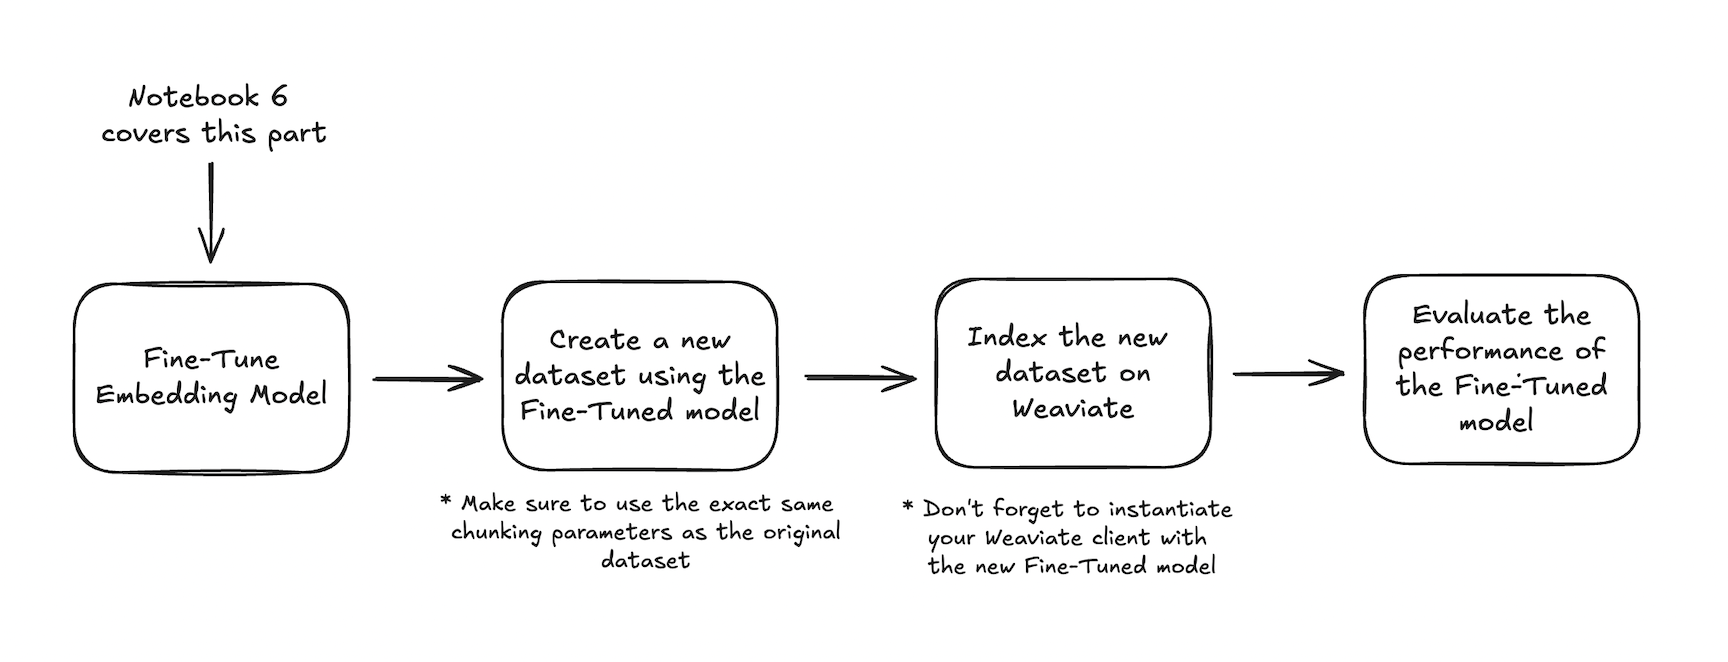


Fine-tuning is just the start!  You still have to create a new dataset using the fine-tuned model, index that data on Weaviate, and then evaluate its performance.  This is why having a solid dataset creation and indexing pipeline is key, especially if you plan on running multiple experiments to optimize your results.  Follow this recipe:  
1. Create new dataset (from Notebook 1)
2. Index that dataset and create an easily identifiable collection name i.e. `Huberman_minilm_finetuned_256` (from Notebook 2)
3. Run the `execute_evaluation` function (from Notebook 4)

Assuming you are in the `notebooks` folder when performing the new evaluation and you have created a `models` folder in the top-level directory, the following code snippet will load the Weaviate client with the fine-tuned model and ensure that you are hitting the right collection for evaluation:  

```
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv(), override=True)
from src.database.weaviate_interface_v4 import WeaviateWCS

api_key = os.environ['WEAVIATE_API_KEY']
url = os.environ['WEAVIATE_ENDPOINT']

model_path = '../models/allminilm-finetuned-256/'

#instantiate client
client = WeaviateWCS(endpoint=url, api_key=api_key, model_name_or_path=model_path)
collection_name = 'Huberman_minilm_finetuned_256'
```